# Frequency Projection

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

import data_cleansing as dc
import data_utils as du

## load the data and apply cleaning steps


In [2]:
data_train_raw, data_test_raw = dc.load_file()

data_test = data_test_raw.copy()
data_train = data_train_raw.copy()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Setup the dataset 
Set the target

In [3]:
data_train['freq'] = data_train['ClaimNb']/data_train['Exposure']
data_test['freq'] = data_test['ClaimNb']/data_test['Exposure']

target_name='freq'


In [4]:
data_train.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,severity,DrivAgeBand,DensityBand,VehAgeBand,freq
RecordID,,,,,,,,,,,,,,,,,,
1,139,1,0.75,F,7,1,61,0.50,B12,Regular,27000,R11,303.00,303.00,"(55,65]","(5e+03,Inf]",1,1.333333
1,190,1,0.14,B,12,5,50,0.60,B12,Diesel,56,R25,1981.84,1981.84,"(45,55]","(50,100]",5,7.142857
1,414,1,0.14,E,4,0,36,0.85,B12,Regular,4792,R11,1456.55,1456.55,"(35,45]","(2e+03,5e+03]",0,7.142857
1,424,2,0.62,F,10,0,51,1.00,B12,Regular,27000,R11,10834.00,5417.00,"(45,55]","(5e+03,Inf]",0,3.225806
1,606,1,0.84,D,10,6,54,0.50,B12,Diesel,583,R93,1840.14,1840.14,"(45,55]","(400,1e+03]",6,1.190476


## Apply lable encoding to the factors

In [5]:

label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand'
                       ]
# encode training data and save encoders used
data_train_encoded, encoders = du.preprocess_labelencode(data_train, label_encode_factors)
# apply trained encoders to test set
data_test_encoded = du.preprocess_labelencode_apply(encoders, data_test, label_encode_factors)

# Setup the Random Forest model

## Split target from factors

In [6]:
#sets used to train (resampled sets)
x_train = data_train_encoded[label_encode_factors].copy()
x_train_weights = data_train_encoded['Exposure']
y_train = data_train_encoded[target_name].copy()

#sets used to predict (and evaluate prediction)
x_test = data_test_encoded[label_encode_factors].copy()
y_test = data_test_encoded[target_name].copy()


## Build the model and predict

use exposure as sample weights

In [7]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=50, 
                                n_estimators=200,
                                max_depth=5,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values,
                    y_train.values,
                    sample_weight=x_train_weights)    


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   16.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   55.4s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   56.7s finished


Wall time: 1min 3s


In [8]:
#predict values
y_train_predicted_rf = clf_rf.predict(x_train.values)    
y_test_predicted_rf = clf_rf.predict(x_test.values)  

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.7s finished


## Merge results back to data set

In [9]:
target_name_predicted = target_name + '_predicted'

out_train = x_train.copy()
out_test = x_test.copy()

out_train[target_name_predicted] = y_train_predicted_rf
out_train[target_name] = y_train
out_test[target_name_predicted] = y_test_predicted_rf
out_test[target_name] = y_test

# Test the results 

In [10]:
# total claim results
train_results_actual= out_train[target_name].sum()
train_results_predict = out_train[target_name_predicted].sum()

test_results_actual= out_test[target_name].sum()
test_results_predict = out_test[target_name_predicted].sum()

# gini results
train_results_gini = du.gini(out_train[target_name].values, out_train[target_name_predicted].values)
test_results_gini = du.gini(out_test[target_name].values, out_test[target_name_predicted].values)
# mean squared error
train_results_mse = np.sqrt(mean_squared_error(out_train[target_name].values, out_train[target_name_predicted].values))
test_results_mse = np.sqrt(mean_squared_error(out_test[target_name].values, out_test[target_name_predicted].values))

print('Total Claims: ', 'Tr Actual {:,.5f}'.format(train_results_actual),
      'Te Actual {:,.5f}'.format(test_results_actual))
print('Total Claims: ', 'Tr Predic {:,.5f}'.format(train_results_predict),
      'Te Predic {:,.5f}'.format(test_results_predict))

print('Gini Results: ',
      'Tr {:,.5f}'.format(train_results_gini),
      'Te {:,.5f}'.format(test_results_gini))
print('RMSE Results: ',
      'Tr {:,.5f}'.format(train_results_mse),
      'Te {:,.5f}'.format(test_results_mse))

print('Factor Importance:\n', pd.DataFrame(zip(clf_rf.feature_importances_, out_train.columns)).sort_values(0, ascending=False))

Total Claims:  Tr Actual 34,647.26801 Te Actual 14,427.95797
Total Claims:  Tr Predic 29,308.57976 Te Predic 12,557.28686
Gini Results:  Tr 0.08990 Te 0.08183
RMSE Results:  Tr 0.56704 Te 0.56979
Factor Importance:
           0            1
5  0.370388  DrivAgeBand
0  0.298322         Area
7  0.081238   VehAgeBand
3  0.067987       VehGas
4  0.060927       Region
1  0.046678     VehPower
2  0.037336     VehBrand
6  0.037124  DensityBand


### Output the results

In [11]:
out_train.to_csv('freq_train.csv')
out_test.to_csv('freq_test.csv')

print(len(out_train), len(out_test))

388192 166367


# Review the Results in Charts

## Plot of distribution of results

In [12]:
#%% plot distribution charts
#x_train_to_predict[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))
#x_test[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))


## Plot of mean claim numbers split by factor level

### Plot fit of data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand
freq_predicted
--target
freq
--target


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


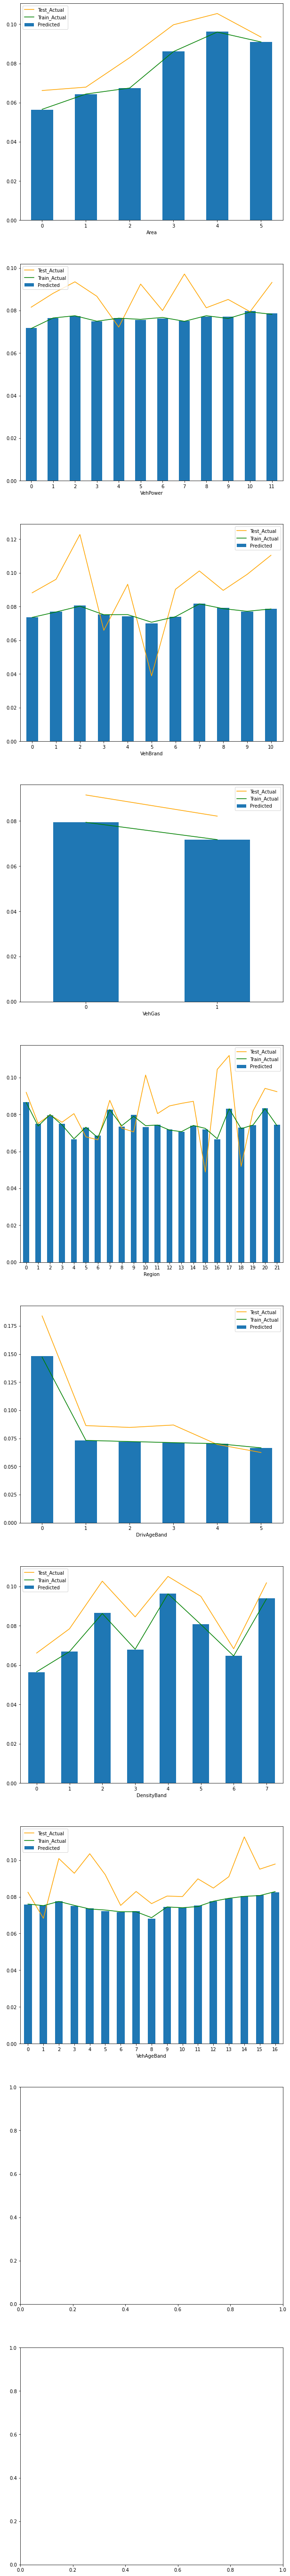

In [13]:
fig = du.plot_factors(out_test, target_name, target_name_predicted, out_train)
fig.show()